# Introduction

**THIS is adjusted fork of https://www.kaggle.com/hoshi7/chaii-pytorch-lightining-w-b**

The model building aspect was taken from: https://www.kaggle.com/rhtsingh/chaii-qa-5-fold-xlmroberta-torch-fit

Over the course of the month, I have learnt a lot about transformers and pytorch. During one such lesson, I stumbled across Pytorch-lightning and how it can create a general framework for the pytorch deep learning model that we are building. 
Keeping that in mind, I set across learning about how to structure regular pytorch code into lightning code. This is one such attempt at that, with WanDB to showcase the ML-OPS part of the training. 

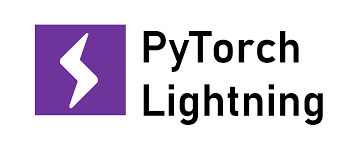

Also, over the course of a lot of learning, I realised that most of the tutorials that can be found easily on the web generally use a prepackaged model such as BertSequenceClassification, this made it difficult to figure out where the _forward_ step should go, or where the linear layers should have gone. Overcoming that obstacle was the main challenge of this notebook, along with finding a way to fit the model on Kaggle's less optimal memory provision. 

Thus, this notebook highlights upon: 
1. Use of custom model (XLM Roberta) with pytorch lightning. 
2. Weights and Biases to showcase the ML-OPS




## Installing and Importing Libraries

Installing pytorch lightning and torch to a newer version as torch 1.7.0 has an error while training with lightning. 

In [ ]:
!pip install -qU '../input/pytorch-lightning-with-hugging-face-transformers/datasets-1.15.1-py3-none-any.whl'
!pip install -qU '../input/pytorch-lightning-with-hugging-face-transformers/huggingface_hub-0.1.2-py3-none-any.whl'
!pip install -qU '../input/pytorch-lightning-with-hugging-face-transformers/tokenizers-0.10.3-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl'
!pip install -qU '../input/pytorch-lightning-with-hugging-face-transformers/transformers-4.12.3-py3-none-any.whl'
!pip install -qU '../input/pytorch-lightning-with-hugging-face-transformers/pytorch_lightning-1.4.9-py3-none-any.whl'

In [ ]:
import os
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

In [ ]:
# Helper libraries
import os
import gc
gc.enable()
import math
import json
import time
import random
import collections
import multiprocessing
from pathlib import Path
import warnings
from argparse import Namespace
from typing import Union

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn import model_selection
from collections import OrderedDict

#Pytorch, transformers
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import transformers
from transformers import (
    WEIGHTS_NAME,
    AdamW,
    AutoConfig,
    AutoModel,
    AutoTokenizer,
    get_scheduler,
    get_cosine_schedule_with_warmup,
    get_linear_schedule_with_warmup,
    logging,
    MODEL_FOR_QUESTION_ANSWERING_MAPPING,
)
logging.set_verbosity_warning()
logging.set_verbosity_error()


#Import pytorch lightning: 
import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning import Callback
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.callbacks import LearningRateMonitor

MODEL_CONFIG_CLASSES = list(MODEL_FOR_QUESTION_ANSWERING_MAPPING.keys())
MODEL_TYPES = tuple(conf.model_type for conf in MODEL_CONFIG_CLASSES)

# Loading data

In [ ]:
train_df = pd.read_csv('../input/chaii-hindi-and-tamil-question-answering/train.csv')
test_df = pd.read_csv('../input/chaii-hindi-and-tamil-question-answering/test.csv')
external_mlqa = pd.read_csv('../input/mlqa-hindi-processed/mlqa_hindi.csv')
external_xquad = pd.read_csv('../input/mlqa-hindi-processed/xquad.csv')
external_train = pd.concat([external_mlqa, external_xquad], ignore_index=True)

del external_mlqa, external_xquad
gc.collect()

## Necessary Functions

The index of necessary functions in order:
- **optimal_num_of_loader_workers**: Find the optimal number of workers based on config. Code from: https://www.kaggle.com/rhtsingh/chaii-qa-5-fold-xlmroberta-torch-fit

In [ ]:
def optimal_num_of_loader_workers():
    num_cpus = multiprocessing.cpu_count()
    num_gpus = torch.cuda.device_count()
    optimal_value = min(num_cpus, num_gpus*4) if num_gpus else num_cpus - 1
    return optimal_value

# Defining Configuration

In [ ]:
config = Namespace(
    seed = 7,
    
    trainer = Namespace(
        precision = 16,
        accumulate_grad_batches = 2,
        max_epochs = 3,
        weights_summary='top',
        num_sanity_val_steps = 0,
        gpus = 1,
        fast_dev_run=True,
#         stochastic_weight_avg=True,
    ),
    
    model = Namespace(
        model_name_or_path = "../input/xlm-roberta-squad2/deepset/xlm-roberta-base-squad2/",
        config_name = "../input/xlm-roberta-squad2/deepset/xlm-roberta-base-squad2/",
        optimizer_type = 'AdamW',
        learning_rate = 3e-5,
        weight_decay = 1e-2,
        epsilon = 1e-8,
        max_grad_norm = 1.0,
        lr_scheduler = 'cosine',
        warmup_ratio = 0.1,
    ),
    
    data = Namespace(
        train_batch_size = 4,
        eval_batch_size = 8,
        tokenizer_name = "../input/xlm-roberta-squad2/deepset/xlm-roberta-base-squad2/",
        max_seq_length = 384,
        doc_stride = 128,
        valid_split = 0.25,
    ),
)

# Dataset class

In [ ]:
class DatasetRetriever(Dataset):
    def __init__(self, features, mode='train'):
        super(DatasetRetriever, self).__init__()
        self.features = features
        self.mode = mode
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, item):   
        feature = self.features[item]
        res = {
            'input_ids': torch.tensor(feature['input_ids'], dtype=torch.long),
            'attention_mask': torch.tensor(feature['attention_mask'], dtype=torch.long),
        }
        if self.mode == 'train':
            res.update({
                'start_position': torch.tensor(feature['start_position'], dtype=torch.long),
                'end_position': torch.tensor(feature['end_position'], dtype=torch.long)
            })
        else:
            res.update({
                'id': feature['example_id'],
                'context': feature['context'],
                'question': feature['question']
            })
            
        return res

# Defining the `LightningDataModule` with Pytorch Lightning


In [ ]:
class DataModuleFit(pl.LightningDataModule):
    def __init__(self, df=None, **kwargs):
        super().__init__()
        self.save_hyperparameters(ignore=['df'])
        self.df = df
        
    def _prepare_features(self, example):
        example["question"] = example["question"].lstrip()
        tokenized_example = self._tokenizer(
            example["question"],
            example["context"],
            truncation="only_second",
            max_length=self.hparams.max_seq_length,
            stride=self.hparams.doc_stride,
            return_overflowing_tokens=True,
            return_offsets_mapping=True,
            padding="max_length",
        )

        sample_mapping = tokenized_example.pop("overflow_to_sample_mapping")
        offset_mapping = tokenized_example.pop("offset_mapping")

        features = []
        for i, offsets in enumerate(offset_mapping):
            feature = {}

            input_ids = tokenized_example["input_ids"][i]
            attention_mask = tokenized_example["attention_mask"][i]

            feature['input_ids'] = input_ids
            feature['attention_mask'] = attention_mask
            feature['offset_mapping'] = offsets

            cls_index = input_ids.index(self._tokenizer.cls_token_id)
            sequence_ids = tokenized_example.sequence_ids(i)

            sample_index = sample_mapping[i]
            answers = example["answers"]

            if len(answers["answer_start"]) == 0:
                feature["start_position"] = cls_index
                feature["end_position"] = cls_index
            else:
                start_char = answers["answer_start"][0]
                end_char = start_char + len(answers["text"][0])

                token_start_index = 0
                while sequence_ids[token_start_index] != 1:
                    token_start_index += 1

                token_end_index = len(input_ids) - 1
                while sequence_ids[token_end_index] != 1:
                    token_end_index -= 1

                if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
                    feature["start_position"] = cls_index
                    feature["end_position"] = cls_index
                else:
                    while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                        token_start_index += 1
                    feature["start_position"] = token_start_index - 1
                    while offsets[token_end_index][1] >= end_char:
                        token_end_index -= 1
                    feature["end_position"] = token_end_index + 1

            features.append(feature)
        return features
        
    def prepare_data(self):
        self._tokenizer = AutoTokenizer.from_pretrained(self.hparams.tokenizer_name)
        
        self.df = self.df.sample(frac=1.)
        train_split = int((1 - self.hparams.valid_split) * df.shape[0])
        train_set = df.iloc[:train_split]
        valid_set = df.iloc[train_split:]

        train_features, valid_features = [[] for _ in range(2)]
        for _, row in train_set.iterrows():
            train_features += self._prepare_features(row)
        for _, row in valid_set.iterrows():
            valid_features += self._prepare_features(row)

        self._train_features = train_features
        self._valid_features = valid_features
        
    def setup(self, stage = None):
        self._train_dset = DatasetRetriever(self._train_features)
        self._valid_dset = DatasetRetriever(self._valid_features)
    
    def train_dataloader(self):
        return DataLoader(
            self._train_dset,
            batch_size=self.hparams.train_batch_size,
            num_workers=optimal_num_of_loader_workers(),
            pin_memory=True,
            drop_last=False,
            shuffle=True
        )

    def val_dataloader(self):
        return DataLoader(
            self._valid_dset,
            batch_size=self.hparams.eval_batch_size,
            num_workers=optimal_num_of_loader_workers(),
            pin_memory=True,
            drop_last=False,
            shuffle=False,
    )
    
class DataModulePredict(DataModuleFit):
    def __init__(self, df, *args, **kwargs):
        super().__init__(df=df)
#         self.save_hyperparameters(ignore=['df'])
#         self.df = df
        
    def _prepare_features(self, example):
        example["question"] = example["question"].lstrip()

        tokenized_example = self._tokenizer(
            example["question"],
            example["context"],
            truncation="only_second",
            max_length=self.hparams.max_seq_length,
            stride=self.hparams.doc_stride,
            return_overflowing_tokens=True,
            return_offsets_mapping=True,
            padding="max_length",
        )

        features = []
        for i in range(len(tokenized_example["input_ids"])):
            feature = {}
            feature["example_id"] = example['id']
            feature['context'] = example['context']
            feature['question'] = example['question']
            feature['input_ids'] = tokenized_example['input_ids'][i]
            feature['attention_mask'] = tokenized_example['attention_mask'][i]
            feature['offset_mapping'] = tokenized_example['offset_mapping'][i]
            feature['sequence_ids'] = [0 if i is None else i for i in tokenized_example.sequence_ids(i)]
            cls_index = feature['input_ids'].index(self._tokenizer.cls_token_id)
            feature['cls_index'] = cls_index
            features.append(feature)

        return features
        
    def prepare_data(self):
        self._tokenizer = AutoTokenizer.from_pretrained(self.hparams.tokenizer_name)
        
        pred_features = []

        for _, row in self.df.iterrows():
            pred_features += self._prepare_features(row)

        self.pred_features = pred_features
        
    def setup(self, stage = None):
        self._pred_dset = DatasetRetriever(self.pred_features, mode='predict')
    
    def predict_dataloader(self):
        return DataLoader(
            self._pred_dset,
            batch_size=self.hparams.eval_batch_size,
            num_workers=optimal_num_of_loader_workers(),
            pin_memory=True,
            drop_last=False,
            shuffle=False
        )    

# Defining the `LightningModule` with Pytorch Lightning

In [ ]:
class Model(pl.LightningModule):

    def __init__(self, **kwargs):
        super().__init__()
        self.save_hyperparameters()
        self.model_config = AutoConfig.from_pretrained(self.hparams.config_name)
        self.model = AutoModel.from_pretrained(self.hparams.model_name_or_path, config=self.model_config)
        self.qa_outputs = nn.Linear(self.model_config.hidden_size, 2)
        self.dropout = nn.Dropout(self.model_config.hidden_dropout_prob)
        self._init_weights(self.qa_outputs)

    def forward(self, input_ids, attention_mask):
        """The forward step performs the next step for the model while training."""
        sequence_output = self.model(input_ids, attention_mask=attention_mask)[0]
        qa_logits = self.qa_outputs(sequence_output)

        start_logits, end_logits = qa_logits.split(1, dim=-1)
        start_logits = start_logits.squeeze(-1)
        end_logits = end_logits.squeeze(-1)

        return start_logits, end_logits
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.model_config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()

    def get_num_training_steps(self) -> int:
        """Total training steps inferred from datamodule and devices."""
        if not getattr(self, "trainer", None):
            raise MisconfigurationException("The LightningModule isn't attached to the trainer yet.")
        if isinstance(self.trainer.limit_train_batches, int) and self.trainer.limit_train_batches != 0:
            num_batches = self.trainer.limit_train_batches
        elif isinstance(self.trainer.limit_train_batches, float):
            # limit_train_batches is a percentage of batches
            dataset_size = len(self.train_dataloader())
            num_batches = int(dataset_size * self.trainer.limit_train_batches)
        else:
            num_batches = len(self.train_dataloader())

        num_devices = max(1, self.trainer.num_gpus, self.trainer.num_processes)
        if self.trainer.tpu_cores:
            num_devices = max(num_devices, self.trainer.tpu_cores)

        effective_batch_size = self.trainer.accumulate_grad_batches * num_devices
        max_estimated_steps = (num_batches // effective_batch_size) * self.trainer.max_epochs

        if self.trainer.max_steps and self.trainer.max_steps < max_estimated_steps:
            return self.trainer.max_steps
        return max_estimated_steps

    @staticmethod
    def _compute_warmup(num_training_steps: int, num_warmup_steps: Union[int, float]) -> int:
        if isinstance(num_warmup_steps, float) and (num_warmup_steps > 1 or num_warmup_steps < 0):
            raise MisconfigurationException("`num_warmup_steps` as float should be provided between 0 and 1.")

        if isinstance(num_warmup_steps, int):
            if num_warmup_steps > num_training_steps:
                raise MisconfigurationException("`num_warmup_steps` as int should be less than `num_training_steps`.")
            return num_warmup_steps
            

        if isinstance(num_warmup_steps, float):
            # Convert float values to percentage of training steps to use as warmup
            num_warmup_steps *= num_training_steps
        return round(num_warmup_steps)                

    def configure_optimizers(self):
        param_optimizer = list(self.model.named_parameters())
        no_decay = ["bias", "LayerNorm.weight"]
        optimizer_grouped_parameters = [
            {
                "params": [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
                "weight_decay_rate": self.hparams.weight_decay
            },
            {
                "params": [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
                "weight_decay_rate": 0.0
            },
        ]
        optimizer = AdamW(optimizer_grouped_parameters, lr=self.hparams.learning_rate, eps = self.hparams.epsilon, correct_bias=True)
        if self.hparams.lr_scheduler is not None:
            num_training_steps = self.get_num_training_steps()
            lr_scheduler = get_scheduler(
                name=self.hparams.lr_scheduler,
                optimizer=optimizer,
                num_warmup_steps=self._compute_warmup(num_training_steps, self.hparams.warmup_ratio),
                num_training_steps=num_training_steps,
            )
            lr_scheduler_config = {
                "scheduler": lr_scheduler,
                "interval": "step",
                "frequency": 1,
            }
            return [optimizer], [lr_scheduler_config]
        return optimizer

#     def configure_optimizers(self):
#         # To be passed to the optimizer (only parameters of the layers you want to update).
#         opt_parameters = []
#         weight_decay = self.hparams.weight_decay    
#         no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
#         named_parameters = list(self.model.named_parameters())
#         def get_lrs(start_lr, last_lr):
#             step = np.abs(np.log(start_lr) - np.log(last_lr)) / 3
#             return [start_lr,  np.exp(np.log(start_lr) + step), np.exp(np.log(start_lr)+2*step), last_lr]
#         def is_decay_param(name: str):
#             return not any(p in name for p in no_decay)
#         ranges = [(0,69), (69, 133), (133, 197), (197, 199)]
#         lrs = get_lrs(1e-8, self.hparams.learning_rate)
#         for _range, lr in zip(ranges, lrs):
#             params = named_parameters[_range[0]:_range[1]]
#             decay_parameters = [p for n, p in params if is_decay_param(n)]
#             no_decay_parameters = [p for n, p in params if not is_decay_param(n)]
#             opt_parameters.append(
#                 {"params": decay_parameters, "weight_decay": weight_decay, "lr": lr}
#             )
#             # According to AAAMLP book by A. Thakur, we generally do not use any decay
#             # for bias and LayerNorm.weight layers.
#             opt_parameters.append(
#                 {"params": no_decay_parameters, "weight_decay": 0.0, "lr": lr}
#             )
#         optimizer = AdamW(opt_parameters, lr=self.hparams.learning_rate, correct_bias=True)
#         if self.hparams.lr_scheduler is not None:
#             num_training_steps = self.get_num_training_steps()
#             lr_scheduler = get_scheduler(
#                 name=self.hparams.lr_scheduler,
#                 optimizer=optimizer,
#                 num_warmup_steps=self._compute_warmup(num_training_steps, self.hparams.warmup_ratio),
#                 num_training_steps=num_training_steps,
#             )
#             lr_scheduler_config = {
#                 "scheduler": lr_scheduler,
#                 "interval": "step",
#                 "frequency": 1,
#             }
#             return [optimizer], [lr_scheduler_config]
#         return optimizer
    
    def _compute_loss(self, preds, labels):
        start_preds, end_preds = preds
        start_labels, end_labels = labels
        start_loss = F.cross_entropy(start_preds, start_labels, ignore_index=-1)
        end_loss = F.cross_entropy(end_preds, end_labels, ignore_index=-1)
        total_loss = (start_loss + end_loss) / 2
        return total_loss
    
    def training_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        targets_start = batch["start_position"]
        targets_end = batch['end_position']
        
        outputs_start, outputs_end = self(input_ids, attention_mask=attention_mask)
        loss = self._compute_loss((outputs_start, outputs_end), (targets_start, targets_end))
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        targets_start = batch["start_position"]
        targets_end = batch['end_position']
        
        outputs_start, outputs_end = self(input_ids, attention_mask=attention_mask)
        loss = self._compute_loss((outputs_start, outputs_end), (targets_start, targets_end))
        self.log('val_loss', loss, prog_bar=True)

    def predict_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        pred_start, pred_end = self(input_ids, attention_mask=attention_mask)
        return {
            'pred_start': pred_start,
            'pred_end': pred_end,
        }

# Train Model with Pytorch lightning

In [ ]:
pl.seed_everything(config.seed)

In [ ]:
df = pd.concat([train_df, external_train], ignore_index=True)
df['answers'] = df[['answer_start', 'answer_text']].apply(lambda x: {'answer_start': [x[0]], 'text': [x[1]]}, axis=1)

test_df['context'] = test_df['context'].apply(lambda x: ' '.join(x.split()))
test_df['question'] = test_df['question'].apply(lambda x: ' '.join(x.split()))

del train_df, external_train
gc.collect()

In [ ]:
# initiate callbacks
lr_monitor = LearningRateMonitor(logging_interval='step')
logger = CSVLogger(save_dir='logs/')
# Checkpoint
ckpt = ModelCheckpoint(
    monitor=f'val_loss',
    save_top_k=1,
    save_last=False,
    save_weights_only=True,
    dirpath='checkpoints',
    filename='{epoch:02d}-{val_loss:.4f}',
    verbose=False,
    mode='min',
)

In [ ]:
model = Model(**vars(config.model))
dm = DataModuleFit(df, **vars(config.data))

trainer = pl.Trainer(
    logger=logger,
    callbacks=[ckpt, lr_monitor],
    **vars(config.trainer)
)
trainer.fit(model, datamodule=dm)

torch.cuda.empty_cache()
del trainer, model, dm
gc.collect()

# Predict with Pytorch lightning

In [ ]:
dm = DataModulePredict(test_df, **vars(config.data))

sub_pred_start = None
sub_pred_end = None
pred_features = None

trainer = pl.Trainer(
    enable_checkpointing=False,
    **vars(config.trainer),
)
model = Model.load_from_checkpoint(ckpt.best_model_path, **vars(config.model))
preds = trainer.predict(model, datamodule=dm)

sub_pred_start = np.vstack([x['pred_start'] for x in preds])
sub_pred_end = np.vstack([x['pred_end'] for x in preds])    
gc.collect()

# Post process the results
Credits: https://www.kaggle.com/kishalmandal/5-folds-infer-combined-model-0-792/

In [ ]:
def postprocess_qa_predictions(examples, features, raw_predictions, n_best_size = 20, max_answer_length = 30):
    all_start_logits, all_end_logits = raw_predictions
    
    example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
    features_per_example = collections.defaultdict(list)
    for i, feature in enumerate(features):
        features_per_example[example_id_to_index[feature["example_id"]]].append(i)

    predictions = []

    print(f"Post-processing {len(examples)} example predictions split into {len(features)} features.")

    for example_index, example in examples.iterrows():
        feature_indices = features_per_example[example_index]

        min_null_score = None
        valid_answers = []
        
        context = example["context"]
        for feature_index in feature_indices:
            start_logits = all_start_logits[feature_index]
            end_logits = all_end_logits[feature_index]

            sequence_ids = features[feature_index]["sequence_ids"]
            context_index = 1

            features[feature_index]["offset_mapping"] = [
                (o if sequence_ids[k] == context_index else None)
                for k, o in enumerate(features[feature_index]["offset_mapping"])
            ]
            offset_mapping = features[feature_index]["offset_mapping"]
            cls_index = features[feature_index]["cls_index"]
            feature_null_score = start_logits[cls_index] + end_logits[cls_index]
            if min_null_score is None or min_null_score < feature_null_score:
                min_null_score = feature_null_score

            start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
            end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    if (
                        start_index >= len(offset_mapping)
                        or end_index >= len(offset_mapping)
                        or offset_mapping[start_index] is None
                        or offset_mapping[end_index] is None
                    ):
                        continue
                    # Don't consider answers with a length that is either < 0 or > max_answer_length.
                    if end_index < start_index or end_index - start_index + 1 > max_answer_length:
                        continue

                    start_char = offset_mapping[start_index][0]
                    end_char = offset_mapping[end_index][1]
                    valid_answers.append(
                        {
                            "score": start_logits[start_index] + end_logits[end_index],
                            "text": context[start_char: end_char]
                        }
                    )
        
        if len(valid_answers) > 0:
            best_answer = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[0]
        else:
            best_answer = {"text": "", "score": 0.0}
        
        predictions.append((example["id"], best_answer["text"]))
        
    return predictions

In [ ]:
processed_preds = postprocess_qa_predictions(test_df, dm.pred_features, (sub_pred_start, sub_pred_end))
sub_df = pd.DataFrame(processed_preds, columns=['id', 'PredictionString'])
sub_df = sub_df.merge(test_df, how='left', on='id')

In [ ]:
bad_starts = [".", ",", "(", ")", "-", "–",  ",", ";"]
bad_endings = ["...", "-", "(", ")", "–", ",", ";"]

tamil_ad = "கி.பி"
tamil_bc = "கி.மு"
tamil_km = "கி.மீ"
hindi_ad = "ई"
hindi_bc = "ई.पू"


cleaned_preds = []
for _, (pred, context) in sub_df[["PredictionString", "context"]].iterrows():
    if pred == "":
        cleaned_preds.append(pred)
        continue
    while any([pred.startswith(y) for y in bad_starts]):
        pred = pred[1:]
    while any([pred.endswith(y) for y in bad_endings]):
        if pred.endswith("..."):
            pred = pred[:-3]
        else:
            pred = pred[:-1]
    if pred.endswith("..."):
            pred = pred[:-3]
    
    if any([pred.endswith(tamil_ad), pred.endswith(tamil_bc), pred.endswith(tamil_km), pred.endswith(hindi_ad), pred.endswith(hindi_bc)]) and pred+"." in context:
        pred = pred+"."
        
    cleaned_preds.append(pred)

sub_df["PredictionString"] = cleaned_preds
sub_df = sub_df[['id', 'PredictionString']]

In [ ]:
sub_df.to_csv('submission.csv', header=True, index=False)

In [ ]:
sub_df.head()